<a href="https://colab.research.google.com/github/maurosc3ner/ml_python_playground/blob/main/courses/udacity_intro_to_tensorflow_for_deep_learning/time_series_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and helpers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def plot_Series(time,series, format="-",start=0,end=None,label=None):
  plt.plot(time[start:end],series[start:end],format,label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def trend(time,slope=0):
  return slope*time

def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*3*np.pi),
                  1/np.exp(2*season_time))
  
def seasonality(time,period,amplitude=1,phase=0):
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=42):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

[   0    1    2 ... 1458 1459 1460]
[ 10.   10.1  10.2 ... 155.8 155.9 156. ]


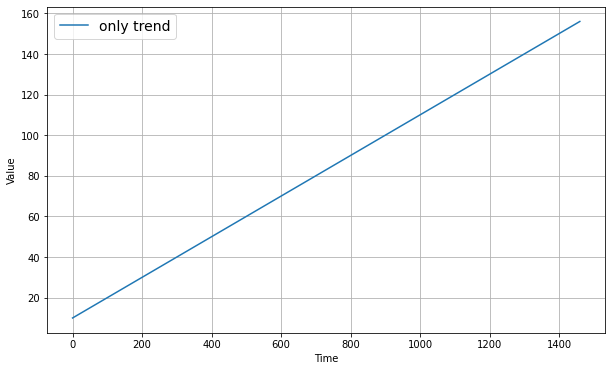

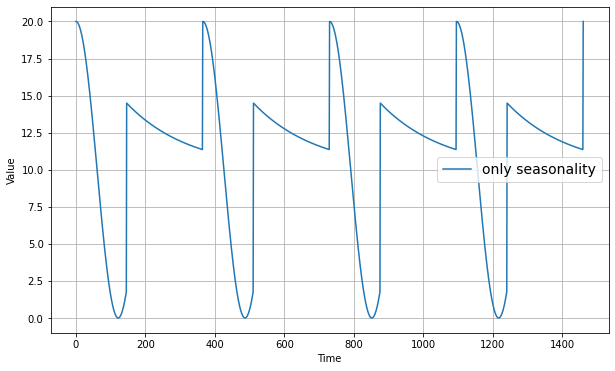

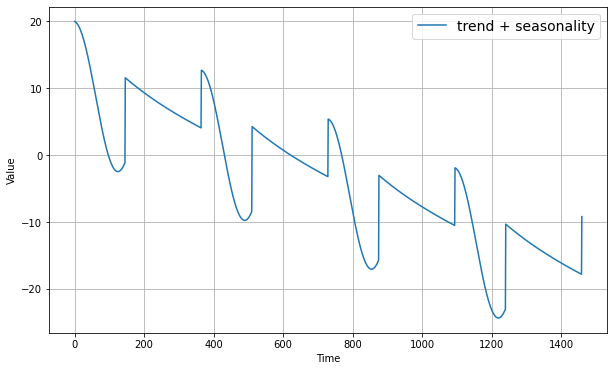

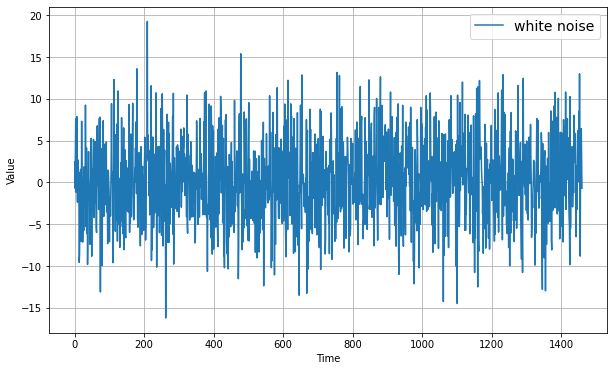

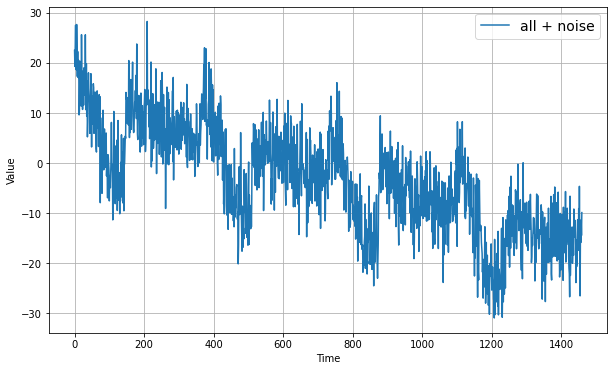

In [ ]:
time=np.arange(4*365+1)
baseline=10
series=baseline+trend(time,0.1)
print(time)
print(series)
plt.figure(figsize=(10,6))
plot_Series(time,series,label="only trend")
plt.show()

amplitude = 10
series = baseline+seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_Series(time, series,label="only seasonality")
plt.show()
# trend
slope = -0.02
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_Series(time, series,label="trend + seasonality")
plt.show()

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_Series(time, noise,label="white noise")
plt.show()

series += noise

plt.figure(figsize=(10, 6))
plot_Series(time, series,label="all + noise")
plt.show()

# Heuristic version

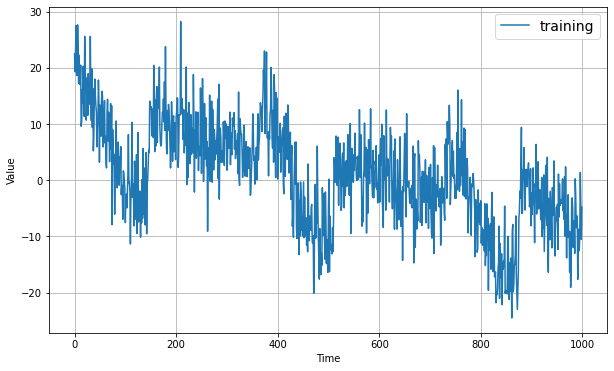

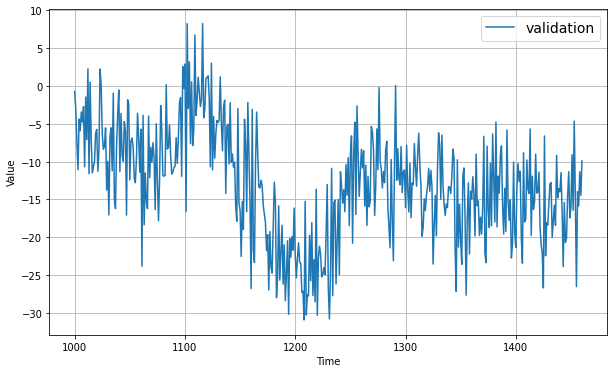

(461,)


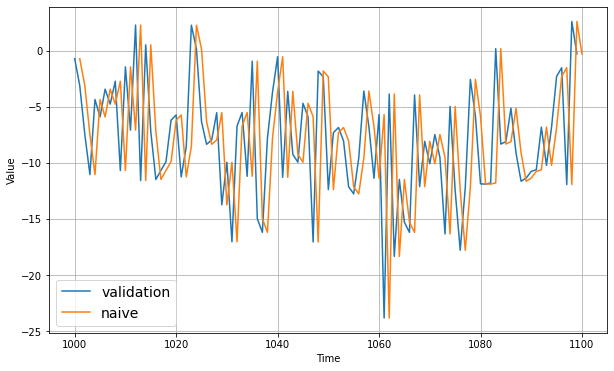

In [ ]:
split_time=1000
tr_series=series[:split_time]
tr_time=time[:split_time]
val_series = series[split_time:]
val_time=time[split_time:]

plt.figure(figsize=(10, 6))
plot_Series(tr_time, tr_series,label="training")
plt.show()

plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series,label="validation")
plt.show()

naive_forecast = series[split_time - 1:-1]
print(naive_forecast.shape)
#zoom
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series,start=0,end=100, label="validation")
plot_Series(val_time, naive_forecast,start=1,end=101,label="naive")
plt.show()

In [ ]:
errors = naive_forecast - val_series
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print(mae)
#using keras metrics
print(tf.keras.metrics.mean_absolute_error(val_series, naive_forecast).numpy())

5.736199322415162
5.736199322415162


# Moving average

Using some measures from the past as the average future (moving average window).

range(0, 1460)
range(0, 1446)


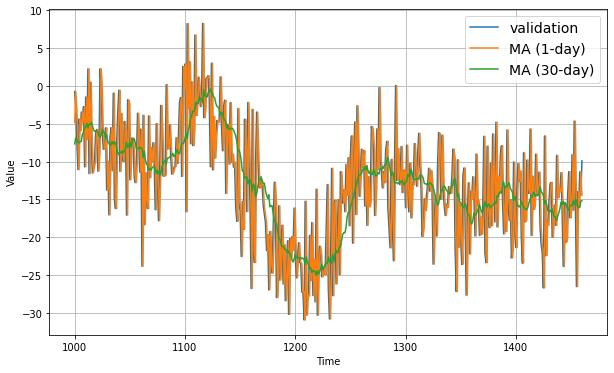

5.736199322415162
4.312160050338288


In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  print(range(len(series) - window_size))
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

mv_avg=moving_average_forecast(series,1)[split_time-1:]
mv_avg2=moving_average_forecast(series,15)[split_time-15:]

#zoom
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="validation")
plot_Series(val_time, mv_avg,label="MA (1-day)")
plot_Series(val_time, mv_avg2,label="MA (30-day)")
plt.show()

print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg2).numpy())

# Moving average 2: removing seasonality

Lets remove the seasonality pattern. We previously know that this is a year pattern.

(1096,)
(1096,)
(1096,)


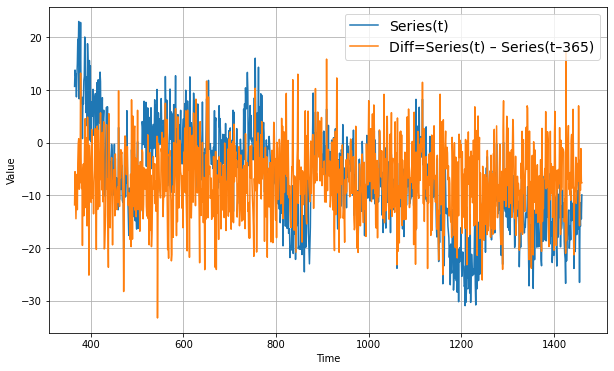

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
print(series[:-365].shape)
print(diff_time.shape)
print(series[365:].shape)
plt.figure(figsize=(10, 6))
plot_Series(diff_time, series[365:], label="Series(t)")
plot_Series(diff_time, diff_series, label="Diff=Series(t) – Series(t–365)")
plt.show()

range(0, 1046)


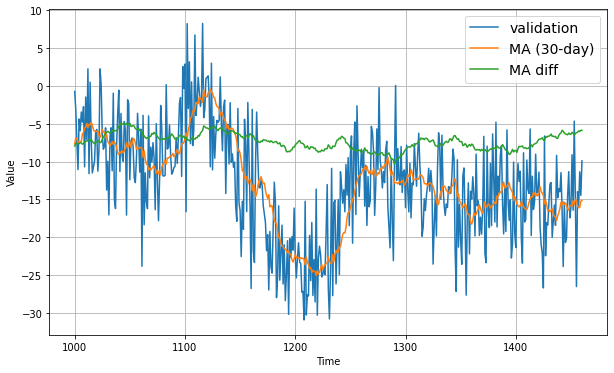

5.736199322415162
7.31591291605542
(461,)
(461,)


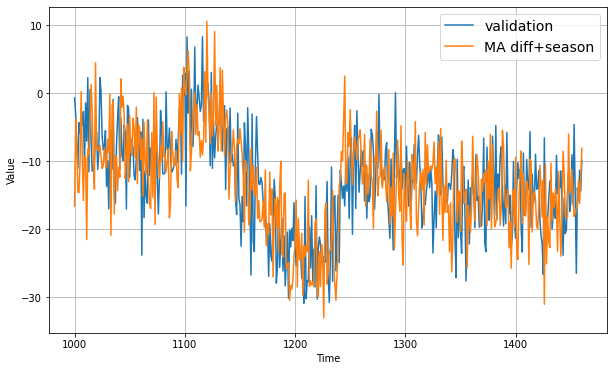

5.839310562995894


In [ ]:
#remember to substract 365 to the split_time
mv_avg3=moving_average_forecast(diff_series,50)[split_time-365-50:]

#zoom
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="validation")
plot_Series(val_time, mv_avg2,label="MA (30-day)")
plot_Series(val_time, mv_avg3,label="MA diff")
plt.show()

print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg3).numpy())

#bring back seasonality
print(mv_avg3.shape)
mv_avg3_ss=mv_avg3+series[split_time-365:-365]
print(mv_avg3_ss.shape)
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="validation")
plot_Series(val_time, mv_avg3_ss,label="MA diff+season")
plt.show()

print(tf.keras.metrics.mean_absolute_error(val_series, mv_avg3_ss).numpy())

range(0, 461)


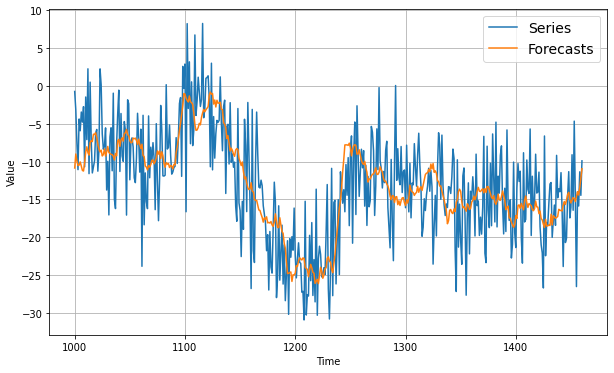

4.215717179734758


In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + mv_avg3

plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="Series")
plot_Series(val_time, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()
print(tf.keras.metrics.mean_absolute_error(val_series, diff_moving_avg_plus_smooth_past).numpy())

# Machine learning

## Pre-processing using Time Windows

First, we will train a model to forecast the next step given the previous 20 steps, therefore, we need to create a dataset of 20-step windows for training.

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Linear model

Epoch 1/200
31/31 [==============================] - 1s 5ms/step - loss: 15.9886 - mae: 16.4805 - lr: 1.0000e-06
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 15.7434 - mae: 16.2352 - lr: 1.0798e-06
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 15.4551 - mae: 15.9471 - lr: 1.1659e-06
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 15.1502 - mae: 15.6424 - lr: 1.2589e-06
Epoch 5/200
31/31 [==============================] - 0s 3ms/step - loss: 14.8190 - mae: 15.3115 - lr: 1.3594e-06
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 14.4662 - mae: 14.9586 - lr: 1.4678e-06
Epoch 7/200
31/31 [==============================] - 0s 2ms/step - loss: 14.0903 - mae: 14.5835 - lr: 1.5849e-06
Epoch 8/200
31/31 [==============================] - 0s 3ms/step - loss: 13.6890 - mae: 14.1823 - lr: 1.7113e-06
Epoch 9/200
31/31 [==============================] - 0s 3ms/step - loss: 13.2638 - mae: 13.7556 

(1e-06, 0.01, 0.0, 20.0)

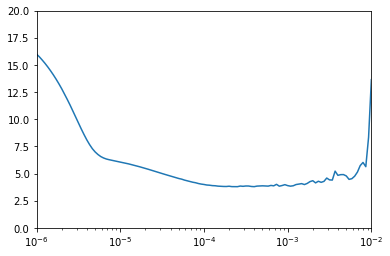

In [ ]:
#clear keras backend and set seed for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
#convert time series arrays to tf train dataset
train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# one neuron model
model1=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size]) # size of the window that used to split previously
])

# dynamic learning rate
#start with a very small learning rate (16-6), and multiply by ten each 30 epochs
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-6 * 10**(epoch/30))

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

model1.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
history1=model1.fit(train_set,epochs=200,callbacks=[lr_schedule])
plt.semilogx(history1.history["lr"], history1.history["loss"],label="learning vs loss")
plt.axis([1e-6, 1e-2, 0, 20])


Based on the plot we can see it is stable up to 10e-4.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# one neuron model
model1=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size]) # size of the window that used to split previously
])

# dynamic learning rate not needed because we already figure it out
#lr_schedule=tf.keras.callbacks.LearningRateScheduler(
 #   lambda epoch:1e-6 * 10**(epoch/30))

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9)
# help to stop if there is not improvement in 10 consecutive epochs
early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
model1.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
model1.fit(train_set,epochs=200,
           validation_data=val_set,
           callbacks=[early_stop])

Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 12.6426 - mae: 13.1340 - val_loss: 6.4952 - val_mae: 6.9791
Epoch 2/200
31/31 [==============================] - 0s 10ms/step - loss: 6.3811 - mae: 6.8680 - val_loss: 6.3736 - val_mae: 6.8547
Epoch 3/200
31/31 [==============================] - 1s 17ms/step - loss: 5.7928 - mae: 6.2770 - val_loss: 5.8331 - val_mae: 6.3135
Epoch 4/200
31/31 [==============================] - 1s 16ms/step - loss: 5.4840 - mae: 5.9683 - val_loss: 5.7508 - val_mae: 6.2311
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 5.2025 - mae: 5.6863 - val_loss: 5.3954 - val_mae: 5.8808
Epoch 6/200
31/31 [==============================] - 0s 7ms/step - loss: 4.9930 - mae: 5.4776 - val_loss: 5.2334 - val_mae: 5.7173
Epoch 7/200
31/31 [==============================] - 0s 7ms/step - loss: 4.8057 - mae: 5.2874 - val_loss: 5.0547 - val_mae: 5.5401
Epoch 8/200
31/31 [==============================] - 0s 7ms/step - loss: 4.64

In [ ]:
def nn_forecast(model,series,ws):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(ws, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(ws))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)
  return forecast
lin_forecast = nn_forecast(model1, series[split_time - window_size:-1], window_size)[:, 0]
lin_forecast.shape

15/15 [==============================] - 0s 14ms/step


(461,)

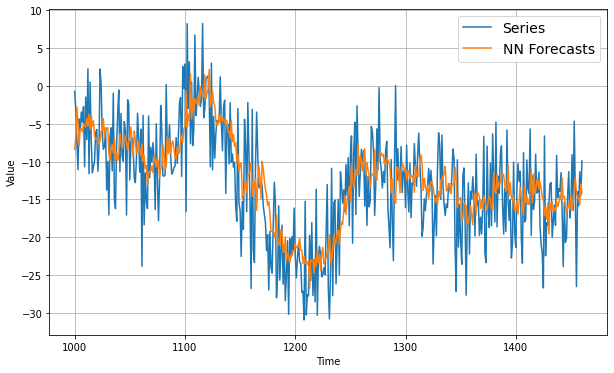

4.349485


In [ ]:
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="Series")
plot_Series(val_time, lin_forecast, label="NN Forecasts")
plt.show()
print(tf.keras.metrics.mean_absolute_error(val_series, lin_forecast).numpy())

## Dense model

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 7.4319 - mae: 7.9178 - val_loss: 20.9732 - val_mae: 21.4728 - lr: 1.0000e-07
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4288 - mae: 7.9147 - val_loss: 20.9565 - val_mae: 21.4561 - lr: 1.1220e-07
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.4250 - mae: 7.9109 - val_loss: 20.9386 - val_mae: 21.4383 - lr: 1.2589e-07
Epoch 4/500
31/31 [==============================] - 1s 15ms/step - loss: 7.4208 - mae: 7.9067 - val_loss: 20.9174 - val_mae: 21.4170 - lr: 1.4125e-07
Epoch 5/500
31/31 [==============================] - 1s 16ms/step - loss: 7.4160 - mae: 7.9019 - val_loss: 20.8935 - val_mae: 21.3932 - lr: 1.5849e-07
Epoch 6/500
31/31 [==============================] - 1s 12ms/step - loss: 7.4107 - mae: 7.8966 - val_loss: 20.8675 - val_mae: 21.3672 - lr: 1.7783e-07
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4048 - mae: 7.8907 - 

(1e-07, 0.01, 0.0, 20.0)

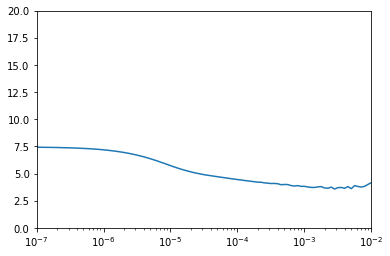

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# hidden layers model
model2=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size]), # size of the window that used to split previously
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1) 
])

# dynamic learning rate not needed because we already figure it out
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-7 * 10**(epoch/20))

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
# help to stop if there is not improvement in 10 consecutive epochs
# early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
model2.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
history2=model2.fit(train_set,epochs=500,
           validation_data=val_set,
           callbacks=[lr_schedule])

plt.semilogx(history2.history["lr"], history2.history["loss"],label="learning vs loss")
plt.axis([1e-7, 1e-2, 0, 20])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set=window_dataset(tr_series,window_size)
val_set=window_dataset(val_series,window_size)

# hidden layers model
model2=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size]), # size of the window that used to split previously
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1) 
])

# dynamic learning rate not needed because we already figure it out
#lr_schedule=tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch:1e-6 * 10**(epoch/30))

# it converges faster than basic SGD
optm=tf.keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9)
# help to stop if there is not improvement in 10 consecutive epochs
early_stop=tf.keras.callbacks.EarlyStopping(patience=10)
model2.compile(loss=tf.keras.losses.Huber(),# well suited for gradient descend
              optimizer=optm,
              metrics=["mae"])
model2.fit(train_set,epochs=500,
           validation_data=val_set,
           callbacks=[early_stop])

Epoch 1/500
31/31 [==============================] - 2s 20ms/step - loss: 5.2970 - mae: 5.7787 - val_loss: 4.6577 - val_mae: 5.1404
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 4.1926 - mae: 4.6695 - val_loss: 4.8092 - val_mae: 5.2878
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 4.0323 - mae: 4.5082 - val_loss: 4.9994 - val_mae: 5.4790
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9344 - mae: 4.4063 - val_loss: 4.2933 - val_mae: 4.7751
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 3.8184 - mae: 4.2890 - val_loss: 4.1472 - val_mae: 4.6197
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 3.7845 - mae: 4.2581 - val_loss: 4.2482 - val_mae: 4.7299
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 3.7713 - mae: 4.2441 - val_loss: 4.0305 - val_mae: 4.5073
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 3.7306 - 

15/15 [==============================] - 15s 7ms/step


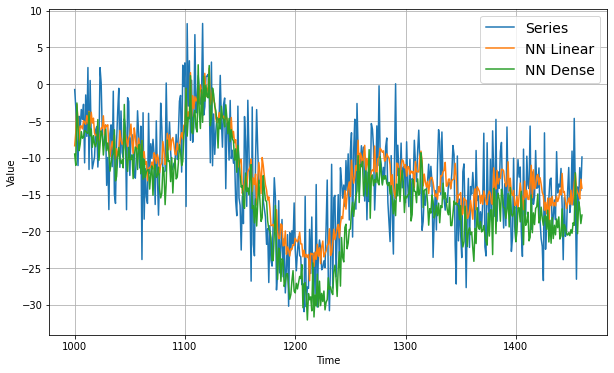

4.954004


In [ ]:
den_forecast = nn_forecast(model2, series[split_time - window_size:-1], window_size)[:, 0]
den_forecast.shape
plt.figure(figsize=(10, 6))
plot_Series(val_time, val_series, label="Series")
plot_Series(val_time, lin_forecast, label="NN Linear")
plot_Series(val_time, den_forecast, label="NN Dense")
plt.show()
print(tf.keras.metrics.mean_absolute_error(val_series, den_forecast).numpy())